# DL_HW3

In [1]:
import numpy as np
import pandas as pd
import time, os, pickle, json, random

from imageio import imread, imwrite
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm, trange
import multiprocessing
from multiprocessing import Pool
from skimage import feature, data, color
import skimage
import cv2
from functools import partial
from sklearn import preprocessing
from sklearn.linear_model import Perceptron

from abc import ABCMeta, abstractmethod

cpus = multiprocessing.cpu_count()
print(cpus)
%autosave 120

160


Autosaving every 120 seconds


## Tool Box

In [2]:
# onehot
def self_onehot(x, c = 50) : 
    x_onehot = np.zeros([x.shape[0], c])
    for i in range(x.shape[0]) :
        x_onehot[i, int(x[i])] = 1
    return x_onehot

# 讀取圖片function
def read_img(path) :
    img = cv2.imread(path)
    img = cv2.resize(img, (256, 256))
    return img


## Read Data and Feature Extraction

In [3]:
# 讀取index
os.chdir('/home/rita/111/111-2DL/HW1')
train_idx = pd.read_table('train.txt', header = None, sep = ' ')
val_idx = pd.read_table('val.txt', header = None, sep = ' ')
test_idx = pd.read_table('test.txt', header = None, delimiter = ' ')
train_idx = np.array(train_idx)
val_idx = np.array(val_idx)
test_idx = np.array(test_idx)
train_y = train_idx[::, 1].astype(float)
val_y = val_idx[::, 1].astype(float)
test_y = test_idx[::, 1].astype(float)
os.chdir('/home/rita/111/111-2DL/HW3')

In [4]:
train_y_onehot = self_onehot(train_y)
val_y_onehot = self_onehot(val_y)
test_y_onehot = self_onehot(test_y)

In [5]:
# class Self_DataLoader() :
#     def __init__(self, data, label, batch_size = 64, shuffle = False) :
#         self.data = data
#         self.label = label
#         self.batch_size = batch_size
#         self.shuffle = shuffle
#         self.n_sample = data.shape[0]
#         self.n_batches = (self.n_sample // self.batch_size) # + 1
#         self.start = 0
#         self.end = self.start + self.batch_size
#         if self.shuffle : np.random.shuffle(np.arange(self.n_sample))
                
#     def __iter__(self):
#         return self
        
#     def __next__(self):
#         if self.end >= self.n_sample :
#             self.start = 0
#             self.end = self.start + self.batch_size
#             if self.shuffle : np.random.shuffle(np.arange(self.n_sample))
#             raise StopIteration
#         datas = self.data[self.start : self.end]
#         labels = self.label[self.start : self.end]
        
#         self.start += self.batch_size
#         self.end += self.batch_size
#         return datas, labels
    
class Self_DataLoader:
    def __init__(self, data, labels, batch_size=32, shuffle=True):
        self.data = data
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.num_samples = data.shape[0]
        self.num_batches = int(np.ceil(self.num_samples / self.batch_size))
        self.indices = np.arange(self.num_samples)
        self.current_batch = 0
        
        if self.shuffle:
            np.random.shuffle(self.indices)
        
    def __iter__(self):
        return self
    
    def __next__(self):
        if self.current_batch >= self.num_batches:
            self.current_batch = 0
            if self.shuffle:
                np.random.shuffle(self.indices)
            raise StopIteration
            
        batch_indices = self.indices[self.current_batch*self.batch_size : (self.current_batch+1)*self.batch_size]
        batch_data = self.data[batch_indices]
        batch_labels = self.labels[batch_indices]
        
        self.current_batch += 1
        
        return batch_data, batch_labels

## Lenet5

In [6]:
# reference : https://github.com/toxtli/lenet-5-mnist-from-scratch-numpy/blob/master/app.py

class FC():
    def __init__(self, D_in, D_out):
        self.cache = None
        self.W = {'val': np.random.normal(0.0, np.sqrt(2/D_in), (D_in,D_out)), 'grad': 0}
        self.b = {'val': np.random.randn(D_out), 'grad': 0}

    def _forward(self, X):
        out = np.dot(X, self.W['val']) + self.b['val']
        self.cache = X
        return out

    def _backward(self, dout):
        X = self.cache
        dX = np.dot(dout, self.W['val'].T).reshape(X.shape)
        self.W['grad'] = np.dot(X.reshape(X.shape[0], np.prod(X.shape[1:])).T, dout)
        self.b['grad'] = np.sum(dout, axis=0)
        #self._update_params()
        return dX

    def _update_params(self, lr=0.001):
        # Update the parameters
        self.W['val'] -= lr*self.W['grad']
        self.b['val'] -= lr*self.b['grad']

class ReLU():
    def __init__(self):
        self.cache = None

    def _forward(self, X):
        out = np.maximum(0, X)
        self.cache = X
        return out

    def _backward(self, dout):
        X = self.cache
        dX = np.array(dout, copy=True)
        dX[X <= 0] = 0
        return dX

class Softmax():
    """
    Softmax activation layer
    """
    def __init__(self):
        #print("Build Softmax")
        self.cache = None

    def _forward(self, X):
        #print("Softmax: _forward")
        maxes = np.amax(X, axis=1)
        maxes = maxes.reshape(maxes.shape[0], 1)
        Y = np.exp(X - maxes)
        Z = Y / np.sum(Y, axis=1).reshape(Y.shape[0], 1)
        self.cache = (X, Y, Z)
        return Z # distribution

    def _backward(self, dout):
        X, Y, Z = self.cache
        dZ = np.zeros(X.shape)
        dY = np.zeros(X.shape)
        dX = np.zeros(X.shape)
        N = X.shape[0]
        for n in range(N):
            i = np.argmax(Z[n])
            dZ[n,:] = np.diag(Z[n]) - np.outer(Z[n],Z[n])
            M = np.zeros((N,N))
            M[:,i] = 1
            dY[n,:] = np.eye(N) - M
        dX = np.dot(dout,dZ)
        dX = np.dot(dX,dY)
        return dX
    
class Conv():
    def __init__(self, Cin, Cout, F, stride=1, padding=0, bias=True):
        self.Cin = Cin
        self.Cout = Cout
        self.F = F
        self.S = stride
        self.W = {'val': np.random.normal(0.0,np.sqrt(2/Cin),(Cout,Cin,F,F)), 'grad': 0} # Xavier Initialization
        self.b = {'val': np.random.randn(Cout), 'grad': 0}
        self.cache = None
        self.pad = padding

    def _forward(self, X):
        X = np.pad(X, ((0,0),(0,0),(self.pad,self.pad),(self.pad,self.pad)), 'constant')
        (N, Cin, H, W) = X.shape
        H_ = H - self.F + 1
        W_ = W - self.F + 1
        Y = np.zeros((N, self.Cout, H_, W_))

        for n in range(N):
            for c in range(self.Cout):
                for h in range(H_):
                    for w in range(W_):
                        Y[n, c, h, w] = np.sum(X[n, :, h:h+self.F, w:w+self.F] * self.W['val'][c, :, :, :]) + self.b['val'][c]

        self.cache = X
        return Y

    def _backward(self, dout):
        # dout (N,Cout,H_,W_)
        # W (Cout, Cin, F, F)
        X = self.cache
        (N, Cin, H, W) = X.shape
        H_ = H - self.F + 1
        W_ = W - self.F + 1
        W_rot = np.rot90(np.rot90(self.W['val']))

        dX = np.zeros(X.shape)
        dW = np.zeros(self.W['val'].shape)
        db = np.zeros(self.b['val'].shape)

        # dW
        for co in range(self.Cout):
            for ci in range(Cin):
                for h in range(self.F):
                    for w in range(self.F):
                        dW[co, ci, h, w] = np.sum(X[:,ci,h:h+H_,w:w+W_] * dout[:,co,:,:])

        # db
        for co in range(self.Cout):
            db[co] = np.sum(dout[:,co,:,:])

        dout_pad = np.pad(dout, ((0,0),(0,0),(self.F,self.F),(self.F,self.F)), 'constant')
        #print("dout_pad.shape: " + str(dout_pad.shape))
        # dX
        for n in range(N):
            for ci in range(Cin):
                for h in range(H):
                    for w in range(W):
                        #print("self.F.shape: %s", self.F)
                        #print("%s, W_rot[:,ci,:,:].shape: %s, dout_pad[n,:,h:h+self.F,w:w+self.F].shape: %s" % ((n,ci,h,w),W_rot[:,ci,:,:].shape, dout_pad[n,:,h:h+self.F,w:w+self.F].shape))
                        dX[n, ci, h, w] = np.sum(W_rot[:,ci,:,:] * dout_pad[n, :, h:h+self.F,w:w+self.F])

        return dX

class MaxPool():
    def __init__(self, F, stride):
        self.F = F
        self.S = stride
        self.cache = None

    def _forward(self, X):
        # X: (N, Cin, H, W): maxpool along 3rd, 4th dim
        (N,Cin,H,W) = X.shape
        F = self.F
        W_ = int(float(W)/F)
        H_ = int(float(H)/F)
        Y = np.zeros((N,Cin,W_,H_))
        M = np.zeros(X.shape) # mask
        for n in range(N):
            for cin in range(Cin):
                for w_ in range(W_):
                    for h_ in range(H_):
                        Y[n,cin,w_,h_] = np.max(X[n,cin,F*w_:F*(w_+1),F*h_:F*(h_+1)])
                        i,j = np.unravel_index(X[n,cin,F*w_:F*(w_+1),F*h_:F*(h_+1)].argmax(), (F,F))
                        M[n,cin,F*w_+i,F*h_+j] = 1
        self.cache = M
        return Y

    def _backward(self, dout):
        M = self.cache
        (N,Cin,H,W) = M.shape
        dout = np.array(dout)
        #print("dout.shape: %s, M.shape: %s" % (dout.shape, M.shape))
        dX = np.zeros(M.shape)
        for n in range(N):
            for c in range(Cin):
                #print("(n,c): (%s,%s)" % (n,c))
                dX[n,c,:,:] = dout[n,c,:,:].repeat(2, axis=0).repeat(2, axis=1)
        return dX*M

def NLLLoss(Y_pred, Y_true):
    """
    Negative log likelihood loss
    """
    loss = 0.0
    N = Y_pred.shape[0]
    M = np.sum(Y_pred*Y_true, axis=1)
    for e in M:
        #print(e)
        if e == 0:
            loss += 500
        else:
            loss += -np.log(e)
    return loss/N
    
class CrossEntropyLoss():
    def __init__(self):
        pass

    def get(self, Y_pred, Y_true):
        N = Y_pred.shape[0]
        softmax = Softmax()
        prob = softmax._forward(Y_pred)
        loss = NLLLoss(prob, Y_true)
        Y_serial = np.argmax(Y_true, axis=1)
        dout = prob.copy()
        dout[np.arange(N), Y_serial] -= 1
        return loss, dout

class Net(metaclass=ABCMeta):
    # Neural network super class

    @abstractmethod
    def __init__(self):
        pass

    @abstractmethod
    def forward(self, X):
        pass

    @abstractmethod
    def backward(self, dout):
        pass

    @abstractmethod
    def get_params(self):
        pass

    @abstractmethod
    def set_params(self, params):
        pass

class SGD():
    def __init__(self, params, lr=0.001, reg=0):
        self.parameters = params
        self.lr = lr
        self.reg = reg

    def step(self):
        for param in self.parameters:
            param['val'] -= (self.lr*param['grad'] + self.reg*param['val'])
    
class SGDMomentum():
    def __init__(self, params, lr=0.001, momentum=0.99, reg=0):
        self.l = len(params)
        self.parameters = params
        self.velocities = []
        for param in self.parameters:
            self.velocities.append(np.zeros(param['val'].shape))
        self.lr = lr
        self.rho = momentum
        self.reg = reg

    def step(self):
        for i in range(self.l):
            self.velocities[i] = self.rho*self.velocities[i] + (1-self.rho)*self.parameters[i]['grad']
            self.parameters[i]['val'] -= (self.lr*self.velocities[i] + self.reg*self.parameters[i]['val'])

def softmax(self, x) :
        return np.exp(x) / np.sum(np.exp(x), axis=1, keepdims = True)
            

### test

In [7]:
class Self_Conv():
    def __init__(self, Cin, Cout, F, stride=1, padding=0, bias=True):
        self.Cin = Cin
        self.Cout = Cout
        self.F = F
        self.S = stride
        self.W = {'val': np.random.normal(0.0,np.sqrt(2/Cin),(Cout,Cin,F,F)), 'grad': 0} # Xavier Initialization
        self.b = {'val': np.random.randn(Cout), 'grad': 0}
        self.cache = None
        self.pad = padding

    def _forward(self, X):
        X = np.pad(X, ((0,0),(0,0),(self.pad,self.pad),(self.pad,self.pad)), 'constant')
        (N, Cin, H, W) = X.shape
        H_ = H - self.F + 1
        W_ = W - self.F + 1
        Y = np.zeros((N, self.Cout, H_, W_))

        # for n in range(N):
        for c in range(self.Cout):
            for h in range(H_):
                for w in range(W_):
                    Y[:, c, h, w] = np.sum(X[:, :, h:h+self.F, w:w+self.F] * self.W['val'][c, :, :, :], axis = (1, 2, 3)) + self.b['val'][c]

        self.cache = X
        return Y

    def _backward(self, dout):
        # dout (N,Cout,H_,W_)
        # W (Cout, Cin, F, F)
        X = self.cache
        (N, Cin, H, W) = X.shape
        H_ = H - self.F + 1
        W_ = W - self.F + 1
        W_rot = np.rot90(np.rot90(self.W['val']))

        dX = np.zeros(X.shape)
        dW = np.zeros(self.W['val'].shape)
        db = np.zeros(self.b['val'].shape)

        # dW
        for co in range(self.Cout):
            for ci in range(Cin):
                for h in range(self.F):
                    for w in range(self.F):
                        dW[co, ci, h, w] = np.sum(X[:,ci,h:h+H_,w:w+W_] * dout[:,co,:,:])
        self.W['grad'] = dW
        # db
        for co in range(self.Cout):
            db[co] = np.sum(dout[:,co,:,:])
        self.b['grad'] = db
        dout_pad = np.pad(dout, ((0,0),(0,0),(self.F,self.F),(self.F,self.F)), 'constant')
        #print("dout_pad.shape: " + str(dout_pad.shape))
        # dX
        # for n in range(N):
        for ci in range(Cin):
            for h in range(H):
                for w in range(W):
                    #print("self.F.shape: %s", self.F)
                    #print("%s, W_rot[:,ci,:,:].shape: %s, dout_pad[n,:,h:h+self.F,w:w+self.F].shape: %s" % ((n,ci,h,w),W_rot[:,ci,:,:].shape, dout_pad[n,:,h:h+self.F,w:w+self.F].shape))
                    dX[:, ci, h, w] = np.sum(W_rot[:,ci,:,:] * dout_pad[:, :, h:h+self.F,w:w+self.F], axis = (1, 2, 3))

        return dX
    
class Self_MaxPool():
    def __init__(self, F, stride):
        self.F = F
        self.S = stride
        self.cache = None

    def _forward(self, X):
        # X: (N, Cin, H, W): maxpool along 3rd, 4th dim
        (N,Cin,H,W) = X.shape
        F = self.F
        W_ = int(float(W)/F)
        H_ = int(float(H)/F)
        Y = np.zeros((N,Cin,W_,H_))
        M = np.zeros(X.shape) # mask
            
        for cin in range(Cin):
            for w_ in range(W_):
                for h_ in range(H_):
                    # Y[:,cin,w_,h_] = np.max(X[:,cin,F*w_:F*(w_+1),F*h_:F*(h_+1)])
                    # i,j = np.unravel_index(X[:,cin,F*w_:F*(w_+1),F*h_:F*(h_+1)].reshape(N, -1).argmax(axis=1), (F,F))
                    # M[:,cin,F*w_+i,F*h_+j] = 1

                    Y[:,cin,w_,h_] = np.max(X[:,cin,F*w_:F*(w_+1),F*h_:F*(h_+1)], axis=(1, 2))
                    i,j = np.unravel_index(X[:,cin,F*w_:F*(w_+1),F*h_:F*(h_+1)].reshape(N, -1).argmax(axis=1), (F,F))
                    M[:,cin,F*w_+i,F*h_+j] = 1
        self.cache = M
        return Y

    def _backward(self, dout):
        M = self.cache
        (N,Cin,H,W) = M.shape
        dout = np.array(dout)
        #print("dout.shape: %s, M.shape: %s" % (dout.shape, M.shape))
        dX = np.zeros(M.shape)
        for c in range(Cin):
            #print("(n,c): (%s,%s)" % (n,c))
            dX[:,c,:,:] = dout[:,c,:,:].repeat(2, axis=1).repeat(2, axis=2)
        return dX*M

class Self_Sigmoid():
    def __init__(self):
        self.cache = None

    def _forward(self, X):
        x = np.float128(X)
        self.cache = 1 / (1 + np.exp(-x))
        return np.float32(self.cache)

    def _backward(self, dout):
        SX = self.cache
        dX = dout*SX*(1-SX)
        return dX
    

In [8]:
class LeNet5(Net):
    # LeNet5

    def __init__(self):
        self.conv1 = Self_Conv(3, 6, 5) # C1(1*32*32 --> 6*28*28)
        self.Self_Sigmoid1 = Self_Sigmoid()
        self.pool1 = Self_MaxPool(2,2) # S2(6*28*28  --> 6*14*14)
        self.conv2 = Self_Conv(6, 16, 5) # C3(6*14*14 --> 16*10*10)
        self.Self_Sigmoid2 = Self_Sigmoid()
        self.pool2 = Self_MaxPool(2,2) # S4(16*5*5)
        self.FC1 = FC(16*5*5, 120) # C5()
        self.Self_Sigmoid3 = Self_Sigmoid()
        self.FC2 = FC(120, 84) # F6
        self.Self_Sigmoid4 = Self_Sigmoid()
        self.FC3 = FC(84, 50)
        self.Softmax = Softmax()

        self.p2_shape = None

    def forward(self, X):
        h1 = self.conv1._forward(X)
        a1 = self.Self_Sigmoid1._forward(h1)
        p1 = self.pool1._forward(a1)
        h2 = self.conv2._forward(p1)
        a2 = self.Self_Sigmoid2._forward(h2)
        p2 = self.pool2._forward(a2)
        self.p2_shape = p2.shape
        fl = p2.reshape(X.shape[0],-1) # Flatten
        h3 = self.FC1._forward(fl)
        a3 = self.Self_Sigmoid3._forward(h3)
        h4 = self.FC2._forward(a3)
        a5 = self.Self_Sigmoid4._forward(h4)
        h5 = self.FC3._forward(a5)
        a5 = self.Softmax._forward(h5)
        return a5

    def backward(self, dout):
        #dout = self.Softmax._backward(dout)
        dout = self.FC3._backward(dout)
        dout = self.Self_Sigmoid4._backward(dout)
        dout = self.FC2._backward(dout)
        dout = self.Self_Sigmoid3._backward(dout)
        dout = self.FC1._backward(dout)
        dout = dout.reshape(self.p2_shape) # reshape
        dout = self.pool2._backward(dout)
        dout = self.Self_Sigmoid2._backward(dout)
        dout = self.conv2._backward(dout)
        dout = self.pool1._backward(dout)
        dout = self.Self_Sigmoid1._backward(dout)
        dout = self.conv1._backward(dout)

    def get_params(self):
        return [self.conv1.W, self.conv1.b, self.conv2.W, self.conv2.b, self.FC1.W, self.FC1.b, self.FC2.W, self.FC2.b, self.FC3.W, self.FC3.b]

    def set_params(self, params):
        [self.conv1.W, self.conv1.b, self.conv2.W, self.conv2.b, self.FC1.W, self.FC1.b, self.FC2.W, self.FC2.b, self.FC3.W, self.FC3.b] = params

In [9]:
# 讀取圖片function
def read_img_32(path) :
    img = cv2.imread(path)
    img = cv2.resize(img, (32, 32))
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img
os.chdir('/home/rita/111/111-2DL/HW1')
if __name__ == '__main__' : 
    with Pool(processes = 80) as p:
        train_pic_32 = list(tqdm(p.imap(read_img_32, train_idx[::, 0], chunksize=100), total = train_idx.shape[0]))
        val_pic_32 = list(tqdm(p.imap(read_img_32, val_idx[::, 0], chunksize=100), total = val_idx.shape[0]))
        test_pic_32 = list(tqdm(p.imap(read_img_32, test_idx[::, 0], chunksize=100), total = test_idx.shape[0]))
os.chdir('/home/rita/111/111-2DL/HW3')

train_pic_32 = np.array(train_pic_32)
val_pic_32 = np.array(val_pic_32)
test_pic_32 = np.array(test_pic_32)

X_train, Y_train, X_test, Y_test = train_pic_32, train_y_onehot, test_pic_32, test_y_onehot
X_val, Y_val = val_pic_32, val_y_onehot
X_train, X_val, X_test = X_train/float(255), X_val/float(255), X_test/float(255)
X_train -= np.mean(X_train)
X_val -= np.mean(X_val)
X_test -= np.mean(X_test)
X_train = np.transpose(X_train, (0, 3, 1, 2))
X_val = np.transpose(X_val, (0, 3, 1, 2))
X_test = np.transpose(X_test, (0, 3, 1, 2))

train_dataloader = Self_DataLoader(X_train, train_y_onehot, batch_size = 32, shuffle=True)
val_dataloader = Self_DataLoader(X_val, val_y_onehot, batch_size = 32, shuffle=True)
test_dataloader = Self_DataLoader(X_test, test_y_onehot, batch_size = 32)

100%|██████████| 450/450 [00:00<00:00, 1025.86it/s]


In [10]:
# zhen
class Self_DataLoader:
    def __init__(self, data, labels, batch_size=32, shuffle=True):
        self.data = data
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.num_samples = data.shape[0]
        self.num_batches = int(np.ceil(self.num_samples / self.batch_size))
        self.indices = np.arange(self.num_samples)
        self.current_batch = 0
        
        if self.shuffle:
            np.random.shuffle(self.indices)
        
    def __iter__(self):
        return self
    
    def __next__(self):
        if self.current_batch >= self.num_batches:
            self.current_batch = 0
            if self.shuffle:
                np.random.shuffle(self.indices)
            raise StopIteration
            
        batch_indices = self.indices[self.current_batch*self.batch_size : (self.current_batch+1)*self.batch_size]
        batch_data = self.data[batch_indices]
        batch_labels = self.labels[batch_indices]
        
        self.current_batch += 1
        
        return batch_data, batch_labels

In [18]:
train_dataloader = Self_DataLoader(X_train, train_y, batch_size = 128, shuffle=True)

model = LeNet5()
optim = SGD(model.get_params(), lr=1e-2, reg=0)
criterion = CrossEntropyLoss()
print('Start Training !')
# TRAIN
# 加 dataloader 版本

def train_lenet5(model, train_loader, n_epochs = 30):
    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []
    for i in range(n_epochs):
        # train
        temp_train_loss, temp_train_acc = 0, 0
        with tqdm(total=train_dataloader.num_batches) as pbar:
            for X_batch, Y_batch in train_dataloader :
                Y_batch = self_onehot(Y_batch)
                Y_pred = model.forward(X_batch)
                loss, _ = criterion.get(Y_pred, Y_batch)
                dout = Y_pred - Y_batch  # pred - label
                model.backward(dout)
                optim.step()
                
                pred_y = np.argmax(Y_pred, axis=1)
                acc = np.mean(pred_y == np.argmax(Y_batch, axis=1))
                
                temp_train_loss += loss
                temp_train_acc += acc
                
                pbar.update(1)
        temp_train_loss /= train_dataloader.num_batches
        temp_train_acc /= train_dataloader.num_batches
        train_acc.append(temp_train_acc)
        train_loss.append(temp_train_loss)
        
        print("%s%% Epoch: %s, loss: %.5f" % (100*i/n_epochs, i + 1, loss))
        
        # validation
        Y_pred = model.forward(X_val)
        pred_y = np.argmax(Y_pred, axis=1)
        acc = np.mean(pred_y == val_y)
        # Y_batch = self_onehot(Y_val)
        loss, _ = criterion.get(Y_pred, Y_val)
        val_loss.append(loss)
        val_acc.append(acc)
    
    return model, train_loss, train_acc, val_loss, val_acc

model, train_loss, train_acc, val_loss, val_acc = train_lenet5(
    model = model, train_loader = train_loader, n_epochs
)


Start Training !


100%|██████████| 495/495 [23:01<00:00,  2.79s/it]


0.0% Epoch: 1, loss: 3.90526


100%|██████████| 495/495 [23:26<00:00,  2.84s/it]


3.3333333333333335% Epoch: 2, loss: 3.89684


100%|██████████| 495/495 [23:37<00:00,  2.86s/it]


6.666666666666667% Epoch: 3, loss: 3.88169


100%|██████████| 495/495 [23:34<00:00,  2.86s/it]


10.0% Epoch: 4, loss: 3.88205


100%|██████████| 495/495 [23:09<00:00,  2.81s/it]


13.333333333333334% Epoch: 5, loss: 3.88309


100%|██████████| 495/495 [22:50<00:00,  2.77s/it]


16.666666666666668% Epoch: 6, loss: 3.86846


100%|██████████| 495/495 [22:48<00:00,  2.76s/it]


20.0% Epoch: 7, loss: 3.85717


100%|██████████| 495/495 [22:43<00:00,  2.75s/it]


23.333333333333332% Epoch: 8, loss: 3.87695


100%|██████████| 495/495 [22:52<00:00,  2.77s/it]


26.666666666666668% Epoch: 9, loss: 3.88154


100%|██████████| 495/495 [22:42<00:00,  2.75s/it]


30.0% Epoch: 10, loss: 3.86455


100%|██████████| 495/495 [22:48<00:00,  2.76s/it]


33.333333333333336% Epoch: 11, loss: 3.86047


100%|██████████| 495/495 [23:10<00:00,  2.81s/it]


36.666666666666664% Epoch: 12, loss: 3.86478


100%|██████████| 495/495 [23:37<00:00,  2.86s/it]


40.0% Epoch: 13, loss: 3.86506


100%|██████████| 495/495 [23:19<00:00,  2.83s/it]


43.333333333333336% Epoch: 14, loss: 3.86859


100%|██████████| 495/495 [23:12<00:00,  2.81s/it]


46.666666666666664% Epoch: 15, loss: 3.83103


100%|██████████| 495/495 [23:30<00:00,  2.85s/it]


50.0% Epoch: 16, loss: 3.85246


100%|██████████| 495/495 [23:14<00:00,  2.82s/it]


53.333333333333336% Epoch: 17, loss: 3.86645


100%|██████████| 495/495 [23:27<00:00,  2.84s/it]


56.666666666666664% Epoch: 18, loss: 3.85494


100%|██████████| 495/495 [23:12<00:00,  2.81s/it]


60.0% Epoch: 19, loss: 3.85621


100%|██████████| 495/495 [23:22<00:00,  2.83s/it]


63.333333333333336% Epoch: 20, loss: 3.84164


100%|██████████| 495/495 [23:04<00:00,  2.80s/it]


66.66666666666667% Epoch: 21, loss: 3.84110


100%|██████████| 495/495 [22:46<00:00,  2.76s/it]


70.0% Epoch: 22, loss: 3.84232


100%|██████████| 495/495 [22:40<00:00,  2.75s/it]


73.33333333333333% Epoch: 23, loss: 3.86079


100%|██████████| 495/495 [22:44<00:00,  2.76s/it]


76.66666666666667% Epoch: 24, loss: 3.84691


100%|██████████| 495/495 [22:53<00:00,  2.77s/it]


80.0% Epoch: 25, loss: 3.83796


100%|██████████| 495/495 [22:42<00:00,  2.75s/it]


83.33333333333333% Epoch: 26, loss: 3.83421


100%|██████████| 495/495 [22:48<00:00,  2.76s/it]


86.66666666666667% Epoch: 27, loss: 3.83510


100%|██████████| 495/495 [22:53<00:00,  2.77s/it]


90.0% Epoch: 28, loss: 3.81750


100%|██████████| 495/495 [22:34<00:00,  2.74s/it]


93.33333333333333% Epoch: 29, loss: 3.86468


100%|██████████| 495/495 [22:36<00:00,  2.74s/it]


96.66666666666667% Epoch: 30, loss: 3.80677


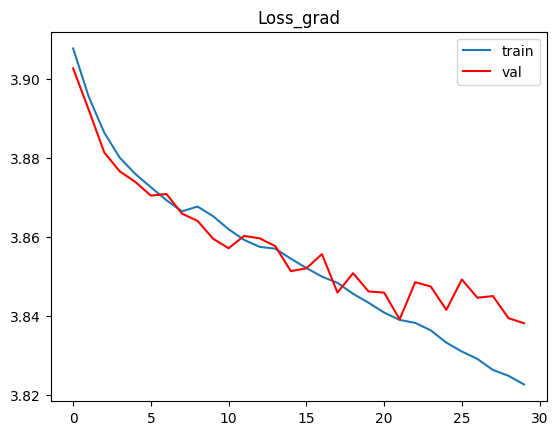

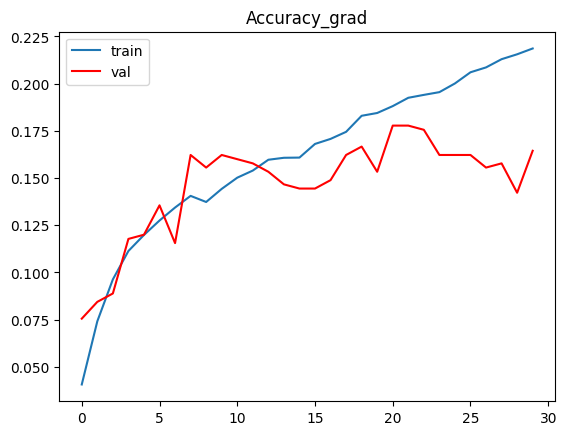

In [19]:
# save params
weights = model.get_params()
with open("./model/lenet5_grad.pkl","wb") as f:
    pickle.dump(weights, f)

with open("./loss/lenet5_train_loss_grad.txt", "w") as fp:
    json.dump(train_loss, fp)
with open("./acc/lenet5_train_acc_grad.txt", "w") as fp:
    json.dump(train_acc, fp)    
with open("./loss/lenet5_val_loss_grad.txt", "w") as fp:
    json.dump(val_loss, fp)   
with open("./acc/lenet5_val_acc_grad.txt", "w") as fp:
    json.dump(val_acc, fp)    
    
# draw
plt.title('Loss_grad')
plt.plot(range(n_epochs), train_loss, label="train")
plt.plot(range(n_epochs), val_loss, label="val", c = 'red')
plt.legend()
plt.savefig('./figure/lenet5_loss_grad.png')
plt.show()

plt.title('Accuracy_grad')
plt.plot(range(n_epochs), train_acc, label="train")
plt.plot(range(n_epochs), val_acc, label="val", c = 'red')
plt.legend()
plt.savefig('./figure/lenet5_acc_grad.png')
plt.show()

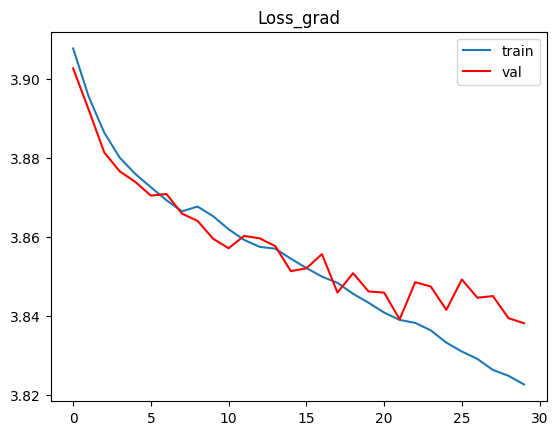

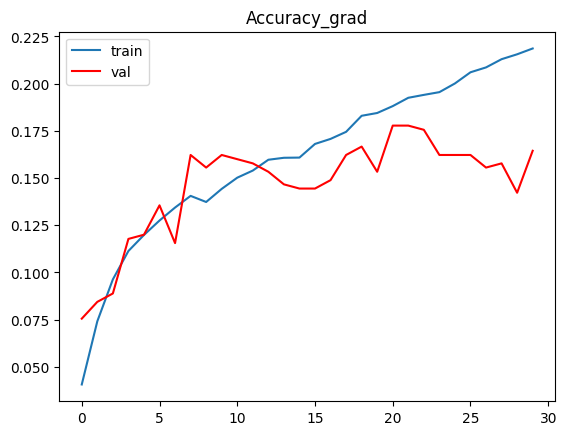

In [13]:
with open("./loss/lenet5_train_loss_grad.txt", "r") as fp:
    train_loss = json.load(fp)
with open("./loss/lenet5_val_loss_grad.txt", "r") as fp:
    val_loss = json.load(fp)
with open("./acc/lenet5_train_acc_grad.txt", "r") as fp:
    train_acc = json.load(fp)
with open("./acc/lenet5_val_acc_grad.txt", "r") as fp:
    val_acc = json.load(fp)
    
# draw
n_epochs = 30
plt.title('Loss_grad')
plt.plot(range(n_epochs), train_loss, label="train")
plt.plot(range(n_epochs), val_loss, label="val", c = 'red')
plt.legend()
plt.savefig('./figure/lenet5_loss_grad.png')
plt.show()

plt.title('Accuracy_grad')
plt.plot(range(n_epochs), train_acc, label="train")
plt.plot(range(n_epochs), val_acc, label="val", c = 'red')
plt.legend()
plt.savefig('./figure/lenet5_acc_grad.png')
plt.show()

In [15]:
with open("/home/rita/111/111-2DL/HW2/model/lenet5_grad.pkl","rb") as fp:
    weight = pickle.load(fp)
    
model = LeNet5()
model.set_params(weight)
optim = SGD(model.get_params(), lr=1e-2, reg=0)
criterion = CrossEntropyLoss()
s = time.time()

Y_pred = model.forward(X_val)
pred_y = np.argmax(Y_pred, axis=1)
acc = np.mean(pred_y == val_y)
print('Val Accuracy : ', acc)

Y_pred = model.forward(X_test)
pred_y = np.argmax(Y_pred, axis=1)
acc = np.mean(pred_y == test_y)
print('Test Accuracy : ', acc)


print(time.time() - s)

Val Accuracy :  0.16444444444444445
Test Accuracy :  0.1688888888888889
6.196697235107422


## Compare

In [11]:
with open("/home/rita/111/111-2DL/HW2//model/lenet5_grad.pkl","rb") as fp:
    weight = pickle.load(fp)
model = LeNet5()
model.set_params(weight)
optim = SGD(model.get_params(), lr=1e-2, reg=0)
criterion = CrossEntropyLoss()

# Inference time
time_start = time.perf_counter()
Y_pred = model.forward(X_test)
pred_y = np.argmax(Y_pred, axis=1)
acc_test = np.mean(pred_y == test_y)
t = time.perf_counter() - time_start
print("Time for Self Lenet : {} s".format(t))

# Accuracy
print('Accuracy for Self Lenet : ', acc_test)


Y_pred = model.forward(X_val)
pred_y = np.argmax(Y_pred, axis=1)
acc_val = np.mean(pred_y == val_y)
print('Accuracy for Self Lenet : ', acc_val)

# Space complexity
# @profile


# flops


Time for Self Lenet : 3.104613250005059 s
Accuracy for Self Lenet :  0.1688888888888889
Accuracy for Self Lenet :  0.16444444444444445


In [38]:
# https://github.com/pythonprofilers/memory_profilerf
from memory_profiler import profile

# @profile(precision=4, @profile(precision=4, stream=open('./memory/memory_profiler.log','w+')))
@profile(precision=4, stream=open('./memory/memory_profiler.log','w+'))
def my_func():
    a = [1] * (10 ** 6)
    b = [2] * (2 * 10 ** 7)
    del b
    return a

if __name__ == '__main__':
    my_func()

ERROR: Could not find file /tmp/ipykernel_1290344/803296413.py


In [12]:
# temp.to_csv('results.csv')
temp = pd.read_csv('results.csv', index_col = [0])
temp.at['Accuracy Test', 'Scratch'] = acc_test
temp.at['Accuracy Val', 'Scratch'] = acc_val
temp.at['Inference Time', 'Scratch'] = t
temp.at['Space Complexity', 'Scratch'] = 98703.9744
# temp.at['FLOPS', 'Scratch'] = 
print(temp)
temp = temp.round(4)
temp.to_csv('results.csv')

                       Scratch     PyTorch       Keras
Accuracy Test         0.168889    0.113333    0.173333
Accuracy Val          0.164444    0.111111    0.155556
Inference Time        3.104613    0.067298    0.239028
Space Complexity  98703.974400  661.640000  255.488000
FLOPS                      NaN   41.925120    0.042345


In [ ]:
Y_pred = model.forward(X_test)
pred_y = np.argmax(Y_pred, axis=1)
acc = np.mean(pred_y == test_y)
t = time.perf_counter() - time_start